In [1]:
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input, decode_predictions

from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array, array_to_img

from keras import Model
from keras.layers import Dense, Flatten
from keras.optimizers import SGD
from keras.utils import to_categorical

Using TensorFlow backend.


In [2]:
vgg = VGG16()

Instructions for updating:
Colocations handled automatically by placer.


In [3]:
def predict_image_using_vgg(img_path, vgg):
    """
    Open image, convert it to an array, and run predictions
    using a trained model.
    """
    # load an image from file
    image = load_img(img_path, target_size=(224, 224))
    # convert the image pixels to a numpy array
    image = img_to_array(image)
    # reshape data for the model
    image = image.reshape(
        (1, image.shape[0], image.shape[1], image.shape[2]))
    image = preprocess_input(image)
    y_pred = vgg.predict(image)
    labels = decode_predictions(y_pred)[0]
    for label in labels:
        print(label)
        

In [5]:
predict_image_using_vgg('../img/mug.jpg', vgg)

('n03063599', 'coffee_mug', 0.75265795)
('n03063689', 'coffeepot', 0.08366192)
('n07930864', 'cup', 0.06439695)
('n04398044', 'teapot', 0.030264096)
('n03950228', 'pitcher', 0.025892278)


### Creating a dataset

In [4]:
import os
import glob
import numpy as np

def create_dataset(folder):
    all_images = []
    image_arrays = []
    all_labels = []
    filenames = []
    for class_id, label in enumerate(os.listdir(folder)):
        print(class_id, label)
        for filename in glob.glob(folder + '/{}/*'.format(label)):
            filenames.append(filename)
            im = load_img(filename, target_size=(224, 224))
            all_images.append(im)
            preprocessed = preprocess_input(img_to_array(im))
            image_arrays.append(preprocessed)
            all_labels.append(class_id)
    X = np.array(image_arrays)
    Y = to_categorical(np.array(all_labels))
    return X, Y, filenames, all_images

In [5]:
X, Y, filenames, all_images = create_dataset('../img/dataset2')

0 araignees
1 coccinelles
2 fourmis


In [6]:
X.shape, Y.shape, len(filenames), len(all_images)

((515, 224, 224, 3), (515, 3), 515, 515)

('n01775062', 'wolf_spider', 0.62954)
('n01774750', 'tarantula', 0.294067)
('n01770393', 'scorpion', 0.02775889)
('n01773549', 'barn_spider', 0.014320607)
('n01978455', 'rock_crab', 0.012125886)


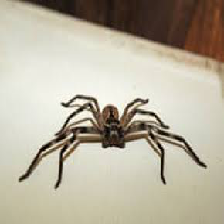

In [7]:
img_id = 29
predict_image_using_vgg(filenames[img_id], vgg)
all_images[img_id]
# ici nous verifions que l'image passée n'est pas dans une categorie deja existante de notre modele

####  TODO Commentaire sur le résultat de VGG16 (est-ce que les classes ont du sens pour notre example ou pas)

In [8]:
# Les classes présentées ici n'ont pas forcément de sens pour notre exemple. En effet,
# ces dernières sont des classes généralistes et nous souhaitons différencier des
# objets qui n'y sont pas présentés
# Nous avons utilisé trois jeux de données :
# 1) araignées, coccinnelles, fourmis
# 2) Cerveaux, poignées de porte, dirigeables
# 3) Tournesols, roses, tulipes
# Le premier cas est déjà présent de base dans VGG16, mais nous avons néanmoins effectué le transfer learning
# Les deux autres cas n'ont pas de classes dans VGG16, le transfer learning est donc impératif

### Transfer learning

In [7]:
# Charger VGG-16 pré-entraîné sur ImageNet
# mais sans les couches fully-connected
vgg_cut = VGG16(weights="imagenet", include_top=False,
                input_shape=(224, 224, 3))
x = vgg_cut.output
# transform matrix into 1-d vector
x = Flatten()(x)

# TODO essayer de modifier le nombre de neurones  
x = Dense(30, activation='relu')(x) 

# TODO parametrer le nombre de classes (9 ici)
nb_classes = 3
x = Dense(nb_classes, activation='softmax')(x)  



In [8]:
custom_model = Model(inputs=vgg_cut.input, outputs=x)

In [9]:
# stratégie de Transfer Learning: extraction de features
# On entraîne seulement le nouveau classificateur,
# et on NE ré-entraîne PAS les autres couches.
# On utilise les autres couches uniquement pour 
# extraire des features des images
for layer in custom_model.layers[:-2]:
    layer.trainable = False

In [10]:
custom_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [11]:
# Compiler le modèle 
custom_model.compile(
    loss="categorical_crossentropy",
    optimizer=SGD(lr=0.0001, momentum=0.9),
    metrics=["accuracy"])

In [12]:
# Entraîner sur toutes les données
# (X_train, Y_train)
custom_model.fit(X, Y,
                 epochs=3, batch_size=100)
# TODO essayer de changer epochs=3 (5, 10)
# 
# En rajoutant des epochs, on améliore la précision
# Cependant, avec 3 epochs on tombe souvent au dessus de 95% de précision, ce qui est déjà très satisfaisant

Instructions for updating:
Use tf.cast instead.
Epoch 1/3
515/515 [==============================] - 625s 1s/step - loss: 3.6730 - acc: 0.6000
Epoch 2/3
515/515 [==============================] - 630s 1s/step - loss: 0.4768 - acc: 0.9282
Epoch 3/3
515/515 [==============================] - 629s 1s/step - loss: 0.1089 - acc: 0.9728


#### Utilisons notre modèle entrainé pour faire des prédictions sur les images de test

In [13]:
# télécharger les images de test (sans libellé, tout dossier TEST)
def load_test_set(folder):
    all_images = []
    image_arrays = []
    filenames = []
    for filename in glob.glob(folder + '/*'):
        filenames.append(filename)
        im = load_img(filename, target_size=(224, 224))
        all_images.append(im)
        preprocessed = preprocess_input(img_to_array(im))
        image_arrays.append(preprocessed)
    X = np.array(image_arrays)
    return X, filenames, all_images

In [14]:
X_test, test_filenames, test_images = load_test_set(
    '../img/tests2/')

In [15]:
X_test.shape

(12, 224, 224, 3)

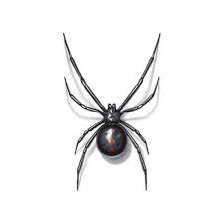

In [16]:
test_id = 7
test_images[test_id]
# on choisit l'image avec un identifiant

In [17]:
def decode(results):
    print("Rose / Araignée / Dirigeable : " + str(results[0][0]))
    print("Tournesol / Coccinnelle / Cerveau : " + str(results[0][1]))
    print("Tulipe / Fourmis / Poignée de porte : " + str(results[0][2]))
    print(results)

img_reshaped = X_test[test_id].reshape(1, *X_test[test_id].shape)
result_pred = custom_model.predict(img_reshaped)
decode(result_pred)
# il s'agit ici de faire la prediction avec l'image que l'on voit au dessus

Rose / Araignée / Dirigeable : 1.0
Tournesol / Coccinnelle / Cerveau : 2.2030387e-36
Tulipe / Fourmis / Poignée de porte : 1.613299e-11
[[1.0000000e+00 2.2030387e-36 1.6132991e-11]]


####  TODO Commentaire sur le résultat des prédiction de notre modèle custom

In [95]:
# Les resultats sont corrects, mais un peu trop précis


# Projet
1. Trouver le sujet de classification d'images
2. Créer le jeu de données:
    * Télécharger les images de l'Internet
    * Utiliser le plugin ""Download All Images"" de navigateur pour aller plus vite:
    * Saisir la requete sur Google Images (par exemple)
    * Cliquer sur "Download All Images" (le plugin du navigateur)
    * Dézipper le fichier téléchargé
    * Récupérer seulement des images pertinentes
    * Mettre ces images dans votre arboscence:
        "img/<nom_de_l_equipe>/<un_dossier_par_catégorie>/*.png"
    * Créer des matrices X et Y à partir des images:
        * itérateur sur les dossiers et les images;
        * chargement des images;
        * preprocessing lié à VGG16 (ou autre modèle CNN préentrainé que vous allez utiliser);
        * création du numpy.array finale depuis la liste des images chargés et prétraités;
        * création du vecteur de "labels" à partir des noms de dossiers parcourus, pour chaque image ("adidas adidas adidas cocacola cocacola fdj fdj fdj fdj ....");
        * conversion du vecteur 1-dimensionnel de labels en vecteur M-dimensionnel, où M = nombre de catégories de votre problème: pour cela, utiliser la fonction *to_categorical*. Chaque label doit donc être un vecteur avec des 0.0 et une seule valeur 1.0 sur la position qui correspond à la bonne catégorie.
        
3. Utiliser un des modèles CNN (convolutional neural network) déjà entrainé (comme VGG ou autre, cf. ici https://keras.io/applications/) pour faire des prédictions sur quelques images de votre dataset. Utiliser "decode_predictions" pour afficher à quelles classes appartient des valeurs maximales du vecteur de prédiction

* Comme votre use case est spécifique, et les classes présentes dans le modèle VGG ne correspondent pas à votre problème. Il faut donc faire du Transfer Learning:
    * Prendre un modèle pré-entrainé (VGG par exemple), mais ne pas utiliser sa dernière couche! (include_top=False). Ne pas oublier de spécifier le format des images en entrée ((224, 224, 3) pour VGG). 
    * Ajouter une couche Flatten() pour aplaitir la matrice pour obtenir le vecteur 1-dimensionnel.
    * Ajouter une couche Dense(nb_classes, activation="softmax")
    * Créer un modele *custom* qui va utiliser ces couches-là.
    * Comme le modèle VGG sera en version "cut" ("truncated"), donc elle ne sera pas utilisé pour les prédictions mais seulement pour extraction de features. Donc, il faut préciser que les couches du modèle custom soit déclarés comme "layer.trainable = False". Utiliser l'itérateur sur "custom_model.layers" afin de préciser quelles couches ne pas entrainer.
    * Vérifier avec "custom_model.summary()" que seulement les paramètres qui correspondent à la dernière couche Dense seront entrainés (cf. les messages "Total parameters, Trainable parameters, Non-Trainable parameters" du summary.
    * Déclarer la méthod de "compilation" du modèle (fonction de perte, algorithme, métrique) avec "custom_model.compile(....)"
    * Finalement, ENTRAINER le modèle avec la commande "custom_modèle.fit". Utiliser plusieurs nombre de *epochs* (plus est mieux, quitte à laisser le modèle s'entrainer pendant plusieurs heures); varier le *batch_size* en fonction de nombre totale d'images dans votre dataset (batch_size plus élevé accélère l'entrainement mais dégrade le résultat; par contre valeur 1 risque de finir par le "overfit", "surapprentissage", où le modèle va apprendre par coeur des exemple, mais mal généraliser sur des nouvelles images, donc le score sera mauvais aussi. Trouver la bonne valeur de batch_size, commenter les étapes de votre expérimentation.
    
    
* Charger des images depuis le dossier "img/test_images", utiliser le même prétraitement afin d'avoir le même format que des matrices X (pas besoin de Y ici, car vous allez juste lancer des prédictions).
* Lancer des prédictions sur ces nouvelles images (custom_model.predict).
* Interpréter des prédictions. Quelle catégorie donne la proba maximale?  Afficher l'image dans notebook pour voir ce qu'elle représente. Est-ce que c'est la bonne catégorie qui a été prédite?


#### Faire un résumé du projet: qu'est-ce que vous avez fait, quels résultats obtenus. Quel score a votre modèle, est-ce qu'elle prédit bien sur des images de test.
#### Commentez votre code!!! 
    
### livrables: GITHUB!!! code + images + requirements.txt, la même arborescence que dl MAIS SANS DOSSIER MYENV!!!  requirements.txt suffira pour recréer "myenv" lors de la correction

### denis.lazarenko@gmail.com


### deadline: 28 avril 2019 , 23:59:59
### questions par mail


#### Liens utils
* training Keras models: 
  https://keras.io/getting-started/sequential-model-guide/
* deep learning tutorial: https://machinelearningmastery.com/use-pre-trained-vgg-model-classify-objects-photographs/
* convolution filter produces a feature map (animation): https://www.youtube.com/watch?v=KiftWz544_8

In [22]:
#Nous avons fait dans ce projet:
# -nous avons essayé trois différents jeux de données. Dans un premier temps, des images assez semblables, 
# des fleurs. Nous avons trouvées celles-ci dans des bases de données disponibles en ligne. Nous n'étions pas
# satisfaits des résultats, alors avons téléchargé des images d'insectes via google images. Les résultats étaient
# bien plus satisfaisants. Enfin, un dernier jeu de données où les images sont très différentes à été utilisé.
# -nous avons verifier que le modele deja existant ne savait pas reconnaître (ce qui était le cas sauf pour les
# insectes), et avons procédé au transer learning
# -nous avons entrainé notre modele en faisant varier le nombre de neuronnes (entre 30 et 50), le nombre d'epochs
# (entre 3 et 5, mais 3 nous donnaies déjà une précision supérieure à 95%) et le batch_size (entre 5 et 100)
# -nous avons vérifié les résultats de l'entrainement avec des images de tests non présentes dans les images
# d'entrainement

# Conclusion : notre modèle reconnait très (trop) bien les différents tests, à l'exception de certaines fleurs
# (il lui arrive de confondre les tournesols et les roses)

# A noter que la précision est très élévé ce qui signifie que le modele est peut-etre proche d'un "overfit"

# NB : pour changer les images d'entrainement et de tests:
# - dataset et tests correspondent aux fleurs
# - dataset2 et tests2 correspondent aux insects
# - dataset3 et tests3 correspondent aux dirigeables, poignées de portes et cerveaux

### 